<a href="https://colab.research.google.com/github/liqiu0202/white_hair_git/blob/main/unet_polyline_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect GDrive

In [ ]:
# install dependencies
!pip install segmentation-models-pytorch albumentations scikit-image --quiet

# For Google Colab Only
from google.colab import drive
import os
drive.mount('/content/drive')
notebook_dir = '/content/drive/MyDrive/Colab Notebooks/white_hair_inference/notebooks'
# Change runtime directory so all files maintain right relative locations
os.chdir(notebook_dir)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.1 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Code Section

In [ ]:
import os
import glob
import json
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import distance_transform_edt

# ==========================================
# 1. UPDATED GENERATOR FUNCTIONS (OmniPose Logic)
# ==========================================

import numpy as np
import cv2

import numpy as np

import numpy as np

def generate_analytical_omnipose_hair(image_shape, polylines, hair_radius=3):
    """
    Generates high-precision analytical targets for OmniPose.
    - dist_ramp: (H, W) - 1.0 at spine, 0.0 at 3px edge.
    - flow_map: (H, W, 2) - Unit vectors pointing to nearest spine point.
    - mask: (H, W) - Binary 1/0 for hair regions.
    """
    h, w = image_shape[:2]
    dist_ramp = np.zeros((h, w), dtype=np.float32)
    flow_map = np.zeros((h, w, 2), dtype=np.float32)
    mask = np.zeros((h, w), dtype=np.uint8) # Binary mask

    # Pre-calculate coordinate grids
    yy, xx = np.mgrid[0:h, 0:w].astype(np.float32)

    for line in polylines:
        line_pts = np.array(line, dtype=np.float32)
        for i in range(len(line_pts) - 1):
            p1, p2 = line_pts[i], line_pts[i+1]

            # --- 1. Define Local Bounding Box ---
            # Pad by 1px to ensure we don't truncate the boundary
            x_min = int(max(0, min(p1[0], p2[0]) - hair_radius - 1))
            x_max = int(min(w, max(p1[0], p2[0]) + hair_radius + 1))
            y_min = int(max(0, min(p1[1], p2[1]) - hair_radius - 1))
            y_max = int(min(h, max(p1[1], p2[1]) + hair_radius + 1))

            if x_max <= x_min or y_max <= y_min:
                continue

            # Extract local grid patch
            lx, ly = xx[y_min:y_max, x_min:x_max], yy[y_min:y_max, x_min:x_max]

            # --- 2. Analytical Geometry ---
            v = p2 - p1
            l2 = np.sum(v**2) + 1e-8
            t = np.clip(((lx - p1[0]) * v[0] + (ly - p1[1]) * v[1]) / l2, 0, 1)

            # Closest point on the segment
            nx, ny = p1[0] + t * v[0], p1[1] + t * v[1]

            dx, dy = nx - lx, ny - ly
            dist = np.sqrt(dx**2 + dy**2)

            # --- 3. Mask & Target Updates ---
            core_mask = dist <= hair_radius

            # 1.0 at spine, 0.0 at 3px edge
            local_ramp = np.clip((hair_radius - dist) / hair_radius, 0, 1) * core_mask

            # Only update pixels where this segment is closer (avoids joint noise)
            update_mask = (local_ramp > dist_ramp[y_min:y_max, x_min:x_max])

            # Update Ramp & Mask
            dist_ramp[y_min:y_max, x_min:x_max][update_mask] = local_ramp[update_mask]
            mask[y_min:y_max, x_min:x_max][core_mask] = 1 # Update mask if within 3px

            # Update Flow (Unit Vectors)
            mag = dist + 1e-8
            flow_map[y_min:y_max, x_min:x_max, 0][update_mask] = dx[update_mask] / mag[update_mask]
            flow_map[y_min:y_max, x_min:x_max, 1][update_mask] = dy[update_mask] / mag[update_mask]

    return dist_ramp, flow_map, mask

# ==========================================
# 2. DATASET CLASS
# ==========================================
def get_pairs(input_dir):
    json_files = sorted(glob.glob(os.path.join(input_dir, "*.json")))
    img_paths, json_paths = [], []
    for j in json_files:
        base = os.path.basename(j).replace('.json', '')
        for ext in ['.jpg', '.png']:
            img_p = os.path.join(input_dir, base + ext)
            if os.path.exists(img_p):
                img_paths.append(img_p)
                json_paths.append(j)
                break
    return img_paths, json_paths

class HairFlowDataset(Dataset):
    def __init__(self, image_paths, json_paths, transform=None):
        self.image_paths = image_paths
        self.json_paths = json_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with open(self.json_paths[idx], 'r') as f:
            data = json.load(f)

        shapes = data.get('shapes', [])
        raw_polylines = [shape['points'] for shape in shapes]
        all_keypoints = [pt for line in raw_polylines for pt in line]
        line_lengths = [len(line) for line in raw_polylines]

        if self.transform:
            augmented = self.transform(image=image, keypoints=all_keypoints)
            image = augmented['image']
            aug_keypoints = augmented['keypoints']

            aug_polylines = []
            cur = 0
            for length in line_lengths:
                line = aug_keypoints[cur : cur + length]
                if len(line) > 1: aug_polylines.append(line)
                cur += length
        else:
            aug_polylines = raw_polylines

        # Generate OmniPose Targets
        h, w = image.shape[:2]
        dist_map, flow_map, mask = generate_analytical_omnipose_hair((h, w), aug_polylines)

        # Convert to Tensors
        tens_trans = ToTensorV2()
        image_t = tens_trans(image=image)['image']
        dist_t = torch.from_numpy(dist_map).unsqueeze(0).float()   # (1, H, W)
        flow_t = torch.from_numpy(flow_map).permute(2, 0, 1).float() # (2, H, W)
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()      # (1, H, W)

        return image_t, dist_t, flow_t, mask_t

# ==========================================
# 3. MODEL WRAPPER
# ==========================================

class HairFlowModel(nn.Module):
    def __init__(self, encoder="tu-hrnet_w18"):
        super().__init__()
        self.base_model = smp.Unet(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=3,
            classes=3, # [0]=Distance, [1,2]=Flow (dx, dy)
            activation=None
        )

    def forward(self, x):
        output = self.base_model(x)
        dist_pred = torch.sigmoid(output[:, 0:1, :, :])
        # Flow vectors use Tanh to allow -1 to 1 range
        flow_pred = torch.tanh(output[:, 1:3, :, :])
        return dist_pred, flow_pred

# ==========================================
# 4. UPDATED LOSS FUNCTION (With Divergence)
# ==========================================

class OmniPoseLoss(nn.Module):
    def __init__(self, dist_w=1.0, flow_w=5.0, div_w=1.0):
        super().__init__()
        self.dist_w = dist_w
        self.flow_w = flow_w
        self.div_w = div_w
        self.mse = nn.MSELoss(reduction='none')
        self.bce = nn.BCEWithLogitsLoss()

    def compute_divergence(self, flow):
        # flow: (B, 2, H, W) -> dx is [0], dy is [1]
        # Using central differences for spatial gradients
        dx = flow[:, 0, :, :]
        dy = flow[:, 1, :, :]

        # d(dx)/dx
        grad_x = (torch.roll(dx, shifts=-1, dims=2) - torch.roll(dx, shifts=1, dims=2)) / 2.0
        # d(dy)/dy
        grad_y = (torch.roll(dy, shifts=-1, dims=1) - torch.roll(dy, shifts=1, dims=1)) / 2.0

        return grad_x + grad_y

    def forward(self, outputs, targets):
        dist_pred, flow_pred = outputs
        dist_gt, flow_gt, mask_gt = targets

        # 1. Distance Map Loss (Masked MSE)
        # We focus more on the hair pixels but keep a small weight on background
        loss_dist = self.mse(dist_pred, dist_gt)
        weight_dist = mask_gt * 0.9 + 0.1
        loss_dist = (loss_dist * weight_dist).mean()

        # 2. Flow Loss (Masked MSE)
        # ONLY compute flow loss where hair exists
        loss_flow = self.mse(flow_pred, flow_gt)
        loss_flow = (loss_flow * mask_gt).sum() / (mask_gt.sum() + 1e-8)

        # 3. Divergence Loss (Structural integrity)
        # div(V) should match the hair mask
        pred_div = self.compute_divergence(flow_pred)
        # Scale divergence by a factor (e.g. 5.0) to help sigmoid saturation
        loss_div = self.bce(pred_div.unsqueeze(1) * 5.0, mask_gt)

        total_loss = (self.dist_w * loss_dist) + (self.flow_w * loss_flow) + (self.div_w * loss_div)

        return total_loss, {
            "total": total_loss.item(),
            "dist_mse": loss_dist.item(),
            "flow_mse": loss_flow.item(),
            "div_bce": loss_div.item()
        }

# ==========================================
# TRAINING SETUP (Simplified)
# ==========================================
# A. Setup Paths
INPUT_DIR = "white_hair_polyline"
if not os.path.exists(INPUT_DIR):
    raise ValueError(f"Directory {INPUT_DIR} not found.")
IMAGE_PATHS, JSON_PATHS = get_pairs(INPUT_DIR)
print(f"Found {len(IMAGE_PATHS)} valid pairs.")
TRAIN_TRANSFORM = A.Compose([
    # 1. Pad Surroundings (Center) with BLACK (0)
    # This ensures that any padded area is treated as "empty/background"
    A.PadIfNeeded(
        min_height=1024,
        min_width=1024,
        position="center",
        border_mode=cv2.BORDER_CONSTANT, # <--- CHANGED: Constant color
        value=0                          # <--- CHANGED: Black (0)
    ),

    # 2. Random Crop
    A.RandomCrop(height=1024, width=1024),

    # 3. Augmentations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # # To avoid modle treat glare lighted black hair as white hair
    # A.RandomGamma(gamma_limit=(10, 100), p=0.5),
    # # 2. Simulate varying lighting/glare conditions
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1, p=0.3),
    A.Normalize()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

VAL_TRANSFORM = A.Compose([
    # Validation: Match training padding logic
    A.PadIfNeeded(
        min_height=1024,
        min_width=1024,
        position="center",
        border_mode=cv2.BORDER_CONSTANT, # <--- CHANGED
        value=0                          # <--- CHANGED
    ),

    # Validation Center Crop
    A.CenterCrop(height=1024, width=1024),

    A.Normalize()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))



# ===========================
# Load dataset
# ===========================
train_imgs, val_imgs, train_jsons, val_jsons = train_test_split(
    IMAGE_PATHS, JSON_PATHS, test_size=0.2, random_state=42
)

train_dataset = HairFlowDataset(train_imgs, train_jsons, transform=TRAIN_TRANSFORM)
val_dataset = HairFlowDataset(val_imgs, val_jsons, transform=VAL_TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)


# -----------------------------------------------------------
# Visualization Helpers
# -----------------------------------------------------------

def flow_to_color(flow_map_numpy):
    """
    Converts (H, W, 2) flow map with (cos2t, sin2t) to RGB
    """
    # flow_map_numpy shape: (H, W, 2)
    h, w, _ = flow_map_numpy.shape

    c2t = flow_map_numpy[:, :, 0]
    s2t = flow_map_numpy[:, :, 1]

    # Calculate magnitude and angle
    magnitude = np.sqrt(c2t**2 + s2t**2)
    angle = np.arctan2(s2t, c2t)

    # Convert angle (-pi to pi) to Hue (0 to 1)
    hue = (angle + np.pi) / (2 * np.pi)

    # Create HSV
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    hsv[..., 0] = hue * 179      # Hue
    hsv[..., 1] = 255            # Saturation
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) # Value

    hsv = hsv.astype(np.uint8)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Mask out low-confidence areas (background) for cleaner look
    rgb[magnitude < 0.1] = 0
    return rgb

def denormalize_image(tensor_img):
    """
    Reverses Albumentations Normalize (ImageNet stats) for display
    tensor_img: (3, H, W)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Convert to numpy (H, W, 3)
    img = tensor_img.permute(1, 2, 0).cpu().numpy()

    # Reverse formula: pixel = (pixel * std) + mean
    img = (img * std) + mean

    # Clip to valid range 0-1
    img = np.clip(img, 0, 1)
    return img


# -----------------------------------------------------------
# INFERENCE Helpers
# -----------------------------------------------------------import torch
import numpy as np
import cv2
import math
import albumentations as A
from albumentations.pytorch import ToTensorV2

def predict_large_image(model, image, tile_size=1024, stride=512, device='cuda'):
    """
    Tiled inference using Overlap + Weighted Blending + Reflection Padding.
    Prevents border artifacts by prioritizing the center of predictions.

    Args:
        tile_size: Input size for the model (e.g., 1024)
        stride: Step size. Recommended to be tile_size // 2 (e.g., 512)
    """
    print('predict large image')
    h, w, _ = image.shape

    # 1. Create a Weight Map (Hanning Window)
    # This gives high value (1.0) to center pixels and low value (0.0) to edges
    # We create a 2D map: (tile_size, tile_size)
    one_d_window = np.hanning(tile_size)
    weight_map = np.outer(one_d_window, one_d_window)

    # 2. Global Padding with Reflection
    # We pad the ENTIRE image first so borders have context.
    # We pad enough so that the window can slide over the original edges freely.
    pad_h = tile_size // 2
    pad_w = tile_size // 2

    image_padded = cv2.copyMakeBorder(
        image, pad_h, pad_h, pad_w, pad_w,
        cv2.BORDER_CONSTANT, value=0  # Matches your "Empty Background" logic
    )

    ph, pw, _ = image_padded.shape

    # 3. Initialize Accumulators (on the Padded size)
    # We accumulate weighted predictions and the sum of weights
    sum_hm = np.zeros((ph, pw), dtype=np.float32)
    sum_flow = np.zeros((ph, pw, 2), dtype=np.float32)
    sum_weights = np.zeros((ph, pw), dtype=np.float32)

    transform = A.Compose([
        A.Normalize(),
        ToTensorV2()
    ])

    model.eval()
    model.to(device)

    # 4. Sliding Window Loop
    # We iterate over the PADDED image
    with torch.no_grad():
        for y in range(0, ph - tile_size + 1, stride):
            for x in range(0, pw - tile_size + 1, stride):

                # Extract Tile
                tile = image_padded[y:y+tile_size, x:x+tile_size]

                # Preprocess
                tile_tensor = transform(image=tile)['image'].unsqueeze(0).to(device)

                # Inference
                output = model(tile_tensor)

                # Simplified: Direct unpacking (Trusting the model returns a tuple)
                heatmap_prob, flow = output

                # Post-process to Numpy
                pred_heatmap = heatmap_prob.squeeze().cpu().numpy()
                pred_flow = flow.squeeze().permute(1, 2, 0).cpu().numpy()

                # 5. Accumulate Weighted Predictions
                # Multiply prediction by the Hanning window (trust center more)
                sum_hm[y:y+tile_size, x:x+tile_size] += pred_heatmap * weight_map
                sum_flow[y:y+tile_size, x:x+tile_size] += pred_flow * weight_map[:, :, None] # Broadcast weight to 2 channels

                # Accumulate the weights themselves so we can average later
                sum_weights[y:y+tile_size, x:x+tile_size] += weight_map

    # 6. Normalize and Crop
    # Divide accumulated predictions by accumulated weights to get the average
    # Avoid division by zero (though with this padding/stride, it shouldn't happen)
    sum_weights[sum_weights == 0] = 1.0

    full_heatmap_padded = sum_hm / sum_weights
    full_flow_padded = sum_flow / sum_weights[:, :, None]

    # Crop back to original image size
    # We remove the pads we added in step 2
    full_heatmap = full_heatmap_padded[pad_h:pad_h+h, pad_w:pad_w+w]
    full_flow = full_flow_padded[pad_h:pad_h+h, pad_w:pad_w+w]

    return full_heatmap, full_flow

Found 2 valid pairs.


/tmp/ipython-input-3968095881.py:246: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/tmp/ipython-input-3968095881.py:270: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


# Visualize custom data loader

(2, 1024, 1024) (64, 64) (64, 64)


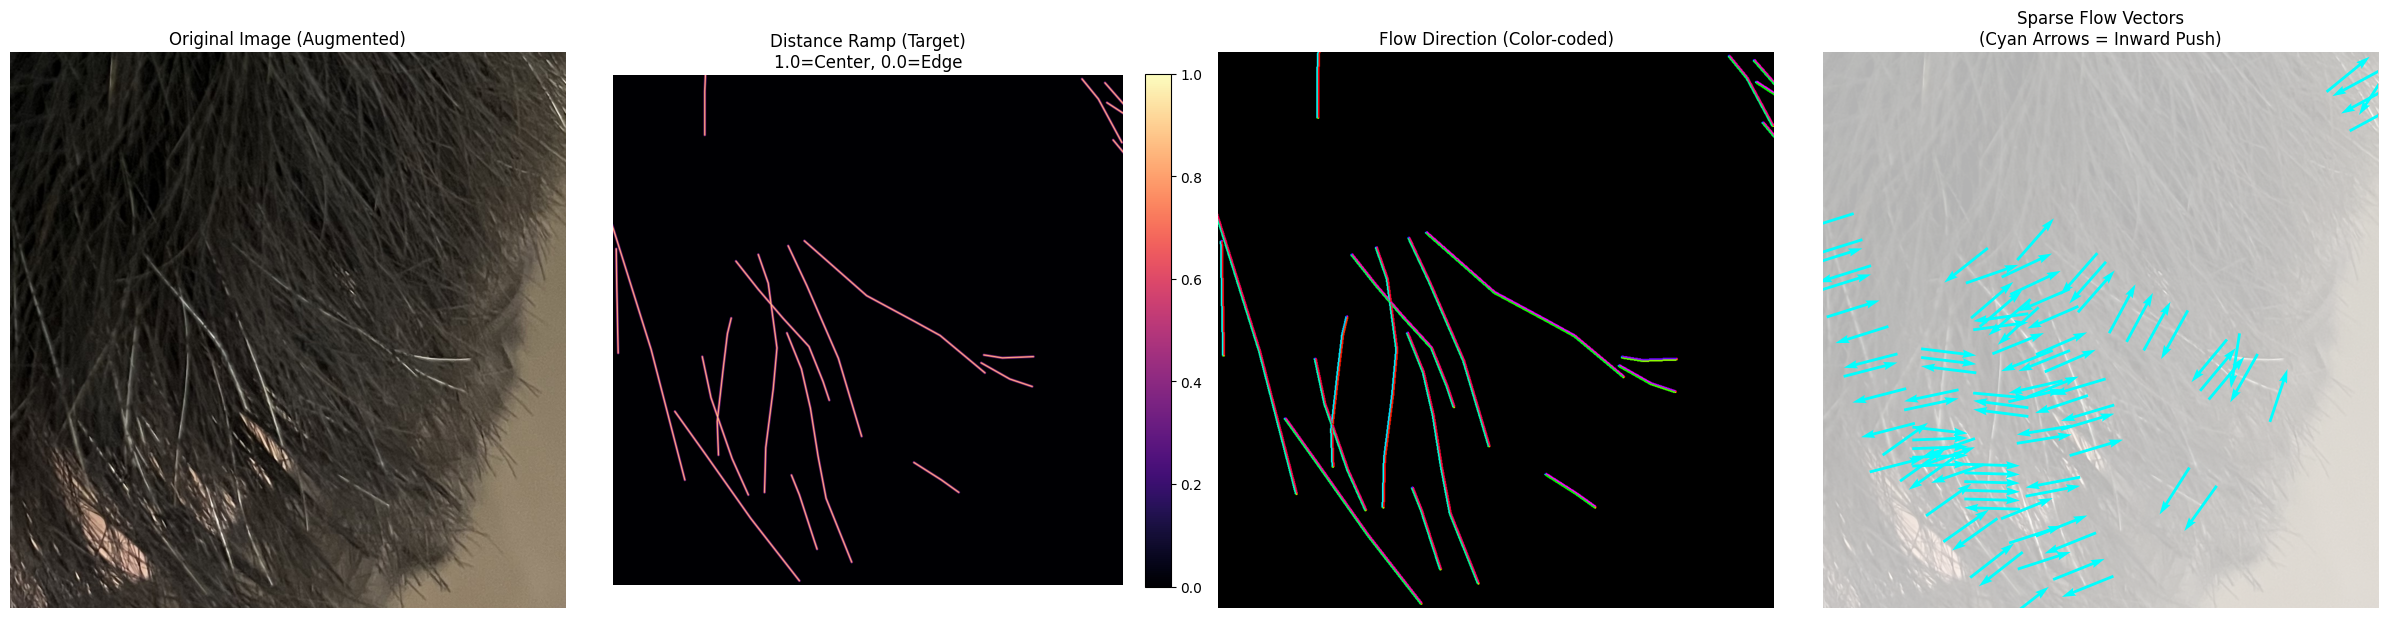

In [ ]:
import matplotlib.pyplot as plt

def visualize_training_sample(image_t, dist_t, flow_t, mask_t):
    """
    Visualizes a single sample from the HairFlowDataset.
    Input tensors: (3, H, W), (1, H, W), (2, H, W), (1, H, W)
    """
    # 1. Denormalize Image
    img = denormalize_image(image_t)

    # 2. Convert Tensors to Numpy
    dist = dist_t.squeeze().cpu().numpy()
    flow = flow_t.cpu().numpy() # (2, H, W)
    mask = mask_t.squeeze().cpu().numpy()

    # 3. Create Visualization Figure
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # --- Subplot 1: Original Image ---
    axes[0].imshow(img)
    axes[0].set_title("Original Image (Augmented)")
    axes[0].axis('off')

    # --- Subplot 2: Distance Ramp (The Target) ---
    im2 = axes[1].imshow(dist, cmap='magma')
    axes[1].set_title("Distance Ramp (Target)\n1.0=Center, 0.0=Edge")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].axis('off')
    plt.imsave('/content/distance_ramp.png', dist, cmap='magma')

    # --- Subplot 3: Flow Orientation (HSV Color) ---
    # Converts (dx, dy) to a color wheel
    flow_rgb = flow_to_color(np.transpose(flow, (1, 2, 0)))
    axes[2].imshow(flow_rgb)
    axes[2].set_title("Flow Direction (Color-coded)")
    axes[2].axis('off')
    # Save flow into image
    plt.imsave('/content/flow_direction.png', flow_rgb)

    # --- Subplot 4: Quick Fix for Readable Vectors ---
    # 1. Background context (Dimmed image)
    axes[3].imshow(img, alpha=0.3)

    # 2. Sparsely sample the grid (1 arrow every 32 pixels)
    step = 16
    h, w = dist.shape
    y, x = np.mgrid[step//2:h:step, step//2:w:step]

    # 3. Extract flow components at those points
    u = flow[0, ::step, ::step]
    v = flow[1, ::step, ::step]

    # 4. Filter: Only plot arrows where there is actually hair (mask > 0)
    # This removes the "sea" of tiny arrows in the background
    m = mask[::step, ::step] > 0.1
    u, v, x, y = u[m], v[m], x[m], y[m]

    # 5. Plot Quiver
    # color='cyan' stands out against dark backgrounds
    # scale=10 makes the arrows longer/shorter based on magnitude
    # pivot='middle' makes the arrow sit centered on the hair
    axes[3].quiver(x, y, u, -v, color='cyan', scale=10, width=0.005, pivot='middle')

    axes[3].set_title("Sparse Flow Vectors\n(Cyan Arrows = Inward Push)")
    axes[3].axis('off')
    # Save the Quiver axis specifically
    extent = axes[3].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('/content/quiver_plot.png', bbox_inches=extent, dpi=300)

    plt.tight_layout()
    plt.show()

# ==========================================
# Run Visualization for the first batch
# ==========================================
example_batch = next(iter(train_loader))
img_t, dist_t, flow_t, mask_t = [t[0] for t in example_batch] # Get first sample from batch

visualize_training_sample(img_t, dist_t, flow_t, mask_t)

# HRNet Backbone
This cell replicates the training pipeline but uses `tu-hrnet_w18` (HRNet) as the encoder backbone.

## Training HRNet

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# ==========================================
# 5. MAIN EXECUTION FOR TRAINING
# ==========================================

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    # Updated tracking for OmniPose metrics
    stats_accumulator = {
        "total": 0.0,
        "dist_mse": 0.0,
        "flow_mse": 0.0,
        "div_bce": 0.0
    }

    pbar = tqdm(loader, desc="Training")
    for images, dist_gt, flow_gt, mask_gt in pbar:
        images = images.to(device)
        dist_gt = dist_gt.to(device)
        flow_gt = flow_gt.to(device)
        mask_gt = mask_gt.to(device)

        # Forward: dist_pred (B,1,H,W), flow_pred (B,2,H,W)
        dist_pred, flow_pred = model(images)

        # OmniPose Loss
        loss, stats = loss_fn((dist_pred, flow_pred), (dist_gt, flow_gt, mask_gt))

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track stats
        for k in stats_accumulator.keys():
            stats_accumulator[k] += stats[k]

        pbar.set_postfix({"loss": f"{stats['total']:.4f}"})

    count = len(loader)
    return {k: v / count for k, v in stats_accumulator.items()}

def validate(model, loader, loss_fn, device):
    model.eval()
    stats_accumulator = {
        "total": 0.0,
        "dist_mse": 0.0,
        "flow_mse": 0.0,
        "div_bce": 0.0
    }

    with torch.no_grad():
        for images, dist_gt, flow_gt, mask_gt in loader:
            images = images.to(device)
            dist_gt = dist_gt.to(device)
            flow_gt = flow_gt.to(device)
            mask_gt = mask_gt.to(device)

            dist_pred, flow_pred = model(images)
            loss, stats = loss_fn((dist_pred, flow_pred), (dist_gt, flow_gt, mask_gt))

            for k in stats_accumulator.keys():
                stats_accumulator[k] += stats[k]

    count = len(loader)
    return {k: v / count for k, v in stats_accumulator.items()}

# --- Initialization ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = 'omnipose_hair_v1.pth'

model = HairFlowModel(encoder="tu-hrnet_w18").to(DEVICE)

# Updated Weights: Flow usually needs higher weight to converge correctly
loss_fn = OmniPoseLoss(dist_w=1.0, flow_w=5.0, div_w=1.0).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=1e-4) # Lower LR often helps flow stability
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# --- Training Loop ---

EPOCHS = 200
VAL_FREQ = 5
best_loss = 1e8
patience = 12
patience_counter = 0

print(f"Starting OmniPose Training on {DEVICE}...")

for epoch in range(EPOCHS):
    # Train
    t_metrics = train_one_epoch(model, train_loader, loss_fn, optimizer, DEVICE)

    log_str = (f"Epoch {epoch+1:03d} | Total: {t_metrics['total']:.4f} | "
               f"Dist: {t_metrics['dist_mse']:.4f} | Flow: {t_metrics['flow_mse']:.4f} | "
               f"Div: {t_metrics['div_bce']:.4f}")
    print(log_str)

    # Validate
    if (epoch + 1) % VAL_FREQ == 0:
        v_metrics = validate(model, val_loader, loss_fn, DEVICE)
        v_loss = v_metrics['total']
        print(f"   >>> Validation Loss: {v_loss:.4f} (Div: {v_metrics['div_bce']:.4f})")

        scheduler.step(v_loss)

        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), SAVE_PATH)
            print(f"   [Model Saved] at {SAVE_PATH}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"   >>> No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("--- Early stopping triggered. ---")
            break

print(f"Training Complete. Best Validation Loss: {best_loss:.4f}")

Starting OmniPose Training on cuda...


Training: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it, loss=8.2859]


Epoch 001 | Total: 8.2859 | Dist: 0.0400 | Flow: 1.4617 | Div: 0.9376


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=8.3752]


Epoch 002 | Total: 8.3752 | Dist: 0.0399 | Flow: 1.4804 | Div: 0.9335


Training: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, loss=8.1512]


Epoch 003 | Total: 8.1512 | Dist: 0.0391 | Flow: 1.4392 | Div: 0.9163


Training: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, loss=7.7599]


Epoch 004 | Total: 7.7599 | Dist: 0.0390 | Flow: 1.3620 | Div: 0.9111


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=7.7318]


Epoch 005 | Total: 7.7318 | Dist: 0.0382 | Flow: 1.3577 | Div: 0.9053
   >>> Validation Loss: 6.0773 (Div: 0.6971)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, loss=7.6164]


Epoch 006 | Total: 7.6164 | Dist: 0.0379 | Flow: 1.3367 | Div: 0.8950


Training: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, loss=7.3368]


Epoch 007 | Total: 7.3368 | Dist: 0.0375 | Flow: 1.2824 | Div: 0.8873


Training: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, loss=7.4579]


Epoch 008 | Total: 7.4579 | Dist: 0.0371 | Flow: 1.3101 | Div: 0.8703


Training: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=7.0649]


Epoch 009 | Total: 7.0649 | Dist: 0.0371 | Flow: 1.2325 | Div: 0.8654


Training: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, loss=7.1006]


Epoch 010 | Total: 7.1006 | Dist: 0.0361 | Flow: 1.2437 | Div: 0.8457
   >>> Validation Loss: 6.1916 (Div: 0.7008)
   >>> No improvement. Patience: 1/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, loss=6.7924]


Epoch 011 | Total: 6.7924 | Dist: 0.0356 | Flow: 1.1846 | Div: 0.8338


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=6.4085]


Epoch 012 | Total: 6.4085 | Dist: 0.0351 | Flow: 1.1099 | Div: 0.8239


Training: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, loss=6.4171]


Epoch 013 | Total: 6.4171 | Dist: 0.0359 | Flow: 1.1147 | Div: 0.8076


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=6.1415]


Epoch 014 | Total: 6.1415 | Dist: 0.0351 | Flow: 1.0603 | Div: 0.8051


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=6.4909]


Epoch 015 | Total: 6.4909 | Dist: 0.0355 | Flow: 1.1306 | Div: 0.8023
   >>> Validation Loss: 6.0044 (Div: 0.7034)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, loss=6.0923]


Epoch 016 | Total: 6.0923 | Dist: 0.0354 | Flow: 1.0540 | Div: 0.7869


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=6.2035]


Epoch 017 | Total: 6.2035 | Dist: 0.0351 | Flow: 1.0784 | Div: 0.7765


Training: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, loss=6.3132]


Epoch 018 | Total: 6.3132 | Dist: 0.0357 | Flow: 1.0980 | Div: 0.7875


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=6.0460]


Epoch 019 | Total: 6.0460 | Dist: 0.0345 | Flow: 1.0487 | Div: 0.7683


Training: 100%|██████████| 1/1 [00:00<00:00,  4.60it/s, loss=5.9265]


Epoch 020 | Total: 5.9265 | Dist: 0.0349 | Flow: 1.0253 | Div: 0.7651
   >>> Validation Loss: 5.7234 (Div: 0.7046)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, loss=5.8895]


Epoch 021 | Total: 5.8895 | Dist: 0.0342 | Flow: 1.0182 | Div: 0.7643


Training: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, loss=6.0153]


Epoch 022 | Total: 6.0153 | Dist: 0.0336 | Flow: 1.0447 | Div: 0.7581


Training: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, loss=5.9057]


Epoch 023 | Total: 5.9057 | Dist: 0.0340 | Flow: 1.0250 | Div: 0.7466


Training: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s, loss=5.8954]


Epoch 024 | Total: 5.8954 | Dist: 0.0335 | Flow: 1.0220 | Div: 0.7518


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=5.8334]


Epoch 025 | Total: 5.8334 | Dist: 0.0344 | Flow: 1.0105 | Div: 0.7467
   >>> Validation Loss: 5.5406 (Div: 0.7050)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, loss=5.6687]


Epoch 026 | Total: 5.6687 | Dist: 0.0337 | Flow: 0.9800 | Div: 0.7351


Training: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, loss=5.8147]


Epoch 027 | Total: 5.8147 | Dist: 0.0339 | Flow: 1.0093 | Div: 0.7343


Training: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=5.7503]


Epoch 028 | Total: 5.7503 | Dist: 0.0336 | Flow: 0.9975 | Div: 0.7294


Training: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, loss=5.7989]


Epoch 029 | Total: 5.7989 | Dist: 0.0340 | Flow: 1.0054 | Div: 0.7382


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, loss=5.8227]


Epoch 030 | Total: 5.8227 | Dist: 0.0347 | Flow: 1.0094 | Div: 0.7408
   >>> Validation Loss: 5.4189 (Div: 0.7034)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, loss=5.6365]


Epoch 031 | Total: 5.6365 | Dist: 0.0336 | Flow: 0.9745 | Div: 0.7304


Training: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, loss=5.6968]


Epoch 032 | Total: 5.6968 | Dist: 0.0338 | Flow: 0.9866 | Div: 0.7302


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=5.7209]


Epoch 033 | Total: 5.7209 | Dist: 0.0339 | Flow: 0.9905 | Div: 0.7347


Training: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=5.6773]


Epoch 034 | Total: 5.6773 | Dist: 0.0333 | Flow: 0.9838 | Div: 0.7251


Training: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, loss=5.6176]


Epoch 035 | Total: 5.6176 | Dist: 0.0339 | Flow: 0.9701 | Div: 0.7330
   >>> Validation Loss: 5.3243 (Div: 0.7020)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, loss=5.6074]


Epoch 036 | Total: 5.6074 | Dist: 0.0326 | Flow: 0.9706 | Div: 0.7220


Training: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s, loss=5.5729]


Epoch 037 | Total: 5.5729 | Dist: 0.0320 | Flow: 0.9640 | Div: 0.7208


Training: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, loss=5.5636]


Epoch 038 | Total: 5.5636 | Dist: 0.0337 | Flow: 0.9603 | Div: 0.7285


Training: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s, loss=5.5532]


Epoch 039 | Total: 5.5532 | Dist: 0.0330 | Flow: 0.9597 | Div: 0.7215


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, loss=5.6045]


Epoch 040 | Total: 5.6045 | Dist: 0.0328 | Flow: 0.9692 | Div: 0.7257
   >>> Validation Loss: 5.2294 (Div: 0.7017)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, loss=5.6045]


Epoch 041 | Total: 5.6045 | Dist: 0.0334 | Flow: 0.9685 | Div: 0.7283


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=5.5945]


Epoch 042 | Total: 5.5945 | Dist: 0.0338 | Flow: 0.9671 | Div: 0.7252


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=5.5744]


Epoch 043 | Total: 5.5744 | Dist: 0.0327 | Flow: 0.9635 | Div: 0.7239


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=5.5429]


Epoch 044 | Total: 5.5429 | Dist: 0.0325 | Flow: 0.9568 | Div: 0.7263


Training: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=5.5025]


Epoch 045 | Total: 5.5025 | Dist: 0.0329 | Flow: 0.9486 | Div: 0.7267
   >>> Validation Loss: 5.1265 (Div: 0.7025)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s, loss=5.5067]


Epoch 046 | Total: 5.5067 | Dist: 0.0320 | Flow: 0.9507 | Div: 0.7213


Training: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, loss=5.4660]


Epoch 047 | Total: 5.4660 | Dist: 0.0316 | Flow: 0.9420 | Div: 0.7243


Training: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, loss=5.5409]


Epoch 048 | Total: 5.5409 | Dist: 0.0320 | Flow: 0.9570 | Div: 0.7239


Training: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, loss=5.3869]


Epoch 049 | Total: 5.3869 | Dist: 0.0324 | Flow: 0.9258 | Div: 0.7257


Training: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, loss=5.4514]


Epoch 050 | Total: 5.4514 | Dist: 0.0325 | Flow: 0.9380 | Div: 0.7289
   >>> Validation Loss: 5.0182 (Div: 0.7037)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, loss=5.4251]


Epoch 051 | Total: 5.4251 | Dist: 0.0324 | Flow: 0.9324 | Div: 0.7306


Training: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, loss=5.3879]


Epoch 052 | Total: 5.3879 | Dist: 0.0319 | Flow: 0.9266 | Div: 0.7230


Training: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, loss=5.4254]


Epoch 053 | Total: 5.4254 | Dist: 0.0320 | Flow: 0.9332 | Div: 0.7272


Training: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, loss=5.4326]


Epoch 054 | Total: 5.4326 | Dist: 0.0322 | Flow: 0.9347 | Div: 0.7272


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=5.4012]


Epoch 055 | Total: 5.4012 | Dist: 0.0318 | Flow: 0.9278 | Div: 0.7302
   >>> Validation Loss: 4.8745 (Div: 0.7056)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, loss=5.2441]


Epoch 056 | Total: 5.2441 | Dist: 0.0323 | Flow: 0.8959 | Div: 0.7323


Training: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=5.4890]


Epoch 057 | Total: 5.4890 | Dist: 0.0315 | Flow: 0.9462 | Div: 0.7265


Training: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, loss=5.4098]


Epoch 058 | Total: 5.4098 | Dist: 0.0319 | Flow: 0.9299 | Div: 0.7283


Training: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, loss=5.4076]


Epoch 059 | Total: 5.4076 | Dist: 0.0312 | Flow: 0.9302 | Div: 0.7251


Training: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, loss=5.3075]


Epoch 060 | Total: 5.3075 | Dist: 0.0314 | Flow: 0.9091 | Div: 0.7306
   >>> Validation Loss: 4.7182 (Div: 0.7084)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, loss=5.3043]


Epoch 061 | Total: 5.3043 | Dist: 0.0318 | Flow: 0.9076 | Div: 0.7345


Training: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, loss=5.3846]


Epoch 062 | Total: 5.3846 | Dist: 0.0308 | Flow: 0.9253 | Div: 0.7274


Training: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, loss=5.2826]


Epoch 063 | Total: 5.2826 | Dist: 0.0317 | Flow: 0.9042 | Div: 0.7298


Training: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, loss=5.3378]


Epoch 064 | Total: 5.3378 | Dist: 0.0314 | Flow: 0.9158 | Div: 0.7271


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=5.2693]


Epoch 065 | Total: 5.2693 | Dist: 0.0308 | Flow: 0.9029 | Div: 0.7238
   >>> Validation Loss: 4.6221 (Div: 0.7105)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s, loss=5.2878]


Epoch 066 | Total: 5.2878 | Dist: 0.0306 | Flow: 0.9063 | Div: 0.7257


Training: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=5.2990]


Epoch 067 | Total: 5.2990 | Dist: 0.0319 | Flow: 0.9064 | Div: 0.7352


Training: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, loss=5.2814]


Epoch 068 | Total: 5.2814 | Dist: 0.0315 | Flow: 0.9032 | Div: 0.7341


Training: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=5.1728]


Epoch 069 | Total: 5.1728 | Dist: 0.0316 | Flow: 0.8826 | Div: 0.7283


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=5.2311]


Epoch 070 | Total: 5.2311 | Dist: 0.0316 | Flow: 0.8934 | Div: 0.7324
   >>> Validation Loss: 4.5728 (Div: 0.7119)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=5.3541]


Epoch 071 | Total: 5.3541 | Dist: 0.0305 | Flow: 0.9183 | Div: 0.7323


Training: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s, loss=5.0796]


Epoch 072 | Total: 5.0796 | Dist: 0.0309 | Flow: 0.8635 | Div: 0.7311


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=5.2164]


Epoch 073 | Total: 5.2164 | Dist: 0.0310 | Flow: 0.8908 | Div: 0.7316


Training: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, loss=5.0753]


Epoch 074 | Total: 5.0753 | Dist: 0.0310 | Flow: 0.8614 | Div: 0.7372


Training: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, loss=5.1257]


Epoch 075 | Total: 5.1257 | Dist: 0.0312 | Flow: 0.8723 | Div: 0.7329
   >>> Validation Loss: 4.4972 (Div: 0.7142)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s, loss=5.2435]


Epoch 076 | Total: 5.2435 | Dist: 0.0308 | Flow: 0.8955 | Div: 0.7350


Training: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, loss=5.0224]


Epoch 077 | Total: 5.0224 | Dist: 0.0310 | Flow: 0.8510 | Div: 0.7363


Training: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=5.0606]


Epoch 078 | Total: 5.0606 | Dist: 0.0318 | Flow: 0.8573 | Div: 0.7423


Training: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, loss=5.2754]


Epoch 079 | Total: 5.2754 | Dist: 0.0307 | Flow: 0.9019 | Div: 0.7353


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, loss=5.2202]


Epoch 080 | Total: 5.2202 | Dist: 0.0299 | Flow: 0.8912 | Div: 0.7342
   >>> Validation Loss: 4.4273 (Div: 0.7173)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s, loss=5.0750]


Epoch 081 | Total: 5.0750 | Dist: 0.0304 | Flow: 0.8627 | Div: 0.7309


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=4.9692]


Epoch 082 | Total: 4.9692 | Dist: 0.0308 | Flow: 0.8403 | Div: 0.7369


Training: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=4.9801]


Epoch 083 | Total: 4.9801 | Dist: 0.0300 | Flow: 0.8429 | Div: 0.7354


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=5.0788]


Epoch 084 | Total: 5.0788 | Dist: 0.0295 | Flow: 0.8635 | Div: 0.7318


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, loss=4.9923]


Epoch 085 | Total: 4.9923 | Dist: 0.0303 | Flow: 0.8449 | Div: 0.7373
   >>> Validation Loss: 4.2412 (Div: 0.7183)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss=5.0303]


Epoch 086 | Total: 5.0303 | Dist: 0.0303 | Flow: 0.8522 | Div: 0.7392


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=5.3296]


Epoch 087 | Total: 5.3296 | Dist: 0.0297 | Flow: 0.9131 | Div: 0.7341


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=5.1066]


Epoch 088 | Total: 5.1066 | Dist: 0.0301 | Flow: 0.8674 | Div: 0.7393


Training: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, loss=5.0621]


Epoch 089 | Total: 5.0621 | Dist: 0.0294 | Flow: 0.8596 | Div: 0.7349


Training: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, loss=4.9944]


Epoch 090 | Total: 4.9944 | Dist: 0.0296 | Flow: 0.8455 | Div: 0.7372
   >>> Validation Loss: 4.1007 (Div: 0.7198)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, loss=4.8246]


Epoch 091 | Total: 4.8246 | Dist: 0.0295 | Flow: 0.8111 | Div: 0.7398


Training: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s, loss=5.1435]


Epoch 092 | Total: 5.1435 | Dist: 0.0292 | Flow: 0.8752 | Div: 0.7383


Training: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, loss=4.7461]


Epoch 093 | Total: 4.7461 | Dist: 0.0296 | Flow: 0.7944 | Div: 0.7445


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.9564]


Epoch 094 | Total: 4.9564 | Dist: 0.0295 | Flow: 0.8368 | Div: 0.7427


Training: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=4.9204]


Epoch 095 | Total: 4.9204 | Dist: 0.0297 | Flow: 0.8288 | Div: 0.7467
   >>> Validation Loss: 4.0267 (Div: 0.7232)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s, loss=4.8434]


Epoch 096 | Total: 4.8434 | Dist: 0.0299 | Flow: 0.8136 | Div: 0.7454


Training: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, loss=4.8702]


Epoch 097 | Total: 4.8702 | Dist: 0.0292 | Flow: 0.8195 | Div: 0.7437


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=4.8071]


Epoch 098 | Total: 4.8071 | Dist: 0.0293 | Flow: 0.8067 | Div: 0.7444


Training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=4.8797]


Epoch 099 | Total: 4.8797 | Dist: 0.0293 | Flow: 0.8211 | Div: 0.7448


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, loss=4.8602]


Epoch 100 | Total: 4.8602 | Dist: 0.0289 | Flow: 0.8172 | Div: 0.7456
   >>> Validation Loss: 3.9743 (Div: 0.7247)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, loss=4.8039]


Epoch 101 | Total: 4.8039 | Dist: 0.0292 | Flow: 0.8055 | Div: 0.7471


Training: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=4.7177]


Epoch 102 | Total: 4.7177 | Dist: 0.0290 | Flow: 0.7892 | Div: 0.7427


Training: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, loss=4.7320]


Epoch 103 | Total: 4.7320 | Dist: 0.0289 | Flow: 0.7915 | Div: 0.7454


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.6555]


Epoch 104 | Total: 4.6555 | Dist: 0.0290 | Flow: 0.7761 | Div: 0.7458


Training: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=4.7841]


Epoch 105 | Total: 4.7841 | Dist: 0.0289 | Flow: 0.8015 | Div: 0.7476
   >>> Validation Loss: 3.9329 (Div: 0.7256)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, loss=4.8367]


Epoch 106 | Total: 4.8367 | Dist: 0.0283 | Flow: 0.8144 | Div: 0.7363


Training: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=4.5993]


Epoch 107 | Total: 4.5993 | Dist: 0.0281 | Flow: 0.7662 | Div: 0.7404


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.8360]


Epoch 108 | Total: 4.8360 | Dist: 0.0284 | Flow: 0.8114 | Div: 0.7506


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=5.0518]


Epoch 109 | Total: 5.0518 | Dist: 0.0275 | Flow: 0.8565 | Div: 0.7419


Training: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, loss=5.0538]


Epoch 110 | Total: 5.0538 | Dist: 0.0278 | Flow: 0.8567 | Div: 0.7428
   >>> Validation Loss: 3.8252 (Div: 0.7280)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, loss=5.0507]


Epoch 111 | Total: 5.0507 | Dist: 0.0284 | Flow: 0.8539 | Div: 0.7529


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, loss=4.8388]


Epoch 112 | Total: 4.8388 | Dist: 0.0280 | Flow: 0.8130 | Div: 0.7458


Training: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s, loss=4.7237]


Epoch 113 | Total: 4.7237 | Dist: 0.0277 | Flow: 0.7901 | Div: 0.7454


Training: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, loss=4.9449]


Epoch 114 | Total: 4.9449 | Dist: 0.0275 | Flow: 0.8358 | Div: 0.7384


Training: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, loss=4.8640]


Epoch 115 | Total: 4.8640 | Dist: 0.0278 | Flow: 0.8183 | Div: 0.7446
   >>> Validation Loss: 3.7623 (Div: 0.7283)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, loss=5.0634]


Epoch 116 | Total: 5.0634 | Dist: 0.0277 | Flow: 0.8592 | Div: 0.7397


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=4.8727]


Epoch 117 | Total: 4.8727 | Dist: 0.0274 | Flow: 0.8207 | Div: 0.7417


Training: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s, loss=4.7996]


Epoch 118 | Total: 4.7996 | Dist: 0.0277 | Flow: 0.8053 | Div: 0.7451


Training: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, loss=4.9400]


Epoch 119 | Total: 4.9400 | Dist: 0.0274 | Flow: 0.8347 | Div: 0.7392


Training: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, loss=4.8472]


Epoch 120 | Total: 4.8472 | Dist: 0.0281 | Flow: 0.8150 | Div: 0.7442
   >>> Validation Loss: 3.8131 (Div: 0.7273)
   >>> No improvement. Patience: 1/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=4.7052]


Epoch 121 | Total: 4.7052 | Dist: 0.0276 | Flow: 0.7872 | Div: 0.7416


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=4.6085]


Epoch 122 | Total: 4.6085 | Dist: 0.0275 | Flow: 0.7678 | Div: 0.7419


Training: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, loss=4.6372]


Epoch 123 | Total: 4.6372 | Dist: 0.0278 | Flow: 0.7735 | Div: 0.7420


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.6734]


Epoch 124 | Total: 4.6734 | Dist: 0.0277 | Flow: 0.7804 | Div: 0.7438


Training: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s, loss=4.5866]


Epoch 125 | Total: 4.5866 | Dist: 0.0279 | Flow: 0.7616 | Div: 0.7507
   >>> Validation Loss: 4.0073 (Div: 0.7248)
   >>> No improvement. Patience: 2/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, loss=5.0087]


Epoch 126 | Total: 5.0087 | Dist: 0.0275 | Flow: 0.8477 | Div: 0.7428


Training: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, loss=4.9703]


Epoch 127 | Total: 4.9703 | Dist: 0.0270 | Flow: 0.8404 | Div: 0.7412


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=5.0468]


Epoch 128 | Total: 5.0468 | Dist: 0.0272 | Flow: 0.8556 | Div: 0.7416


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.8282]


Epoch 129 | Total: 4.8282 | Dist: 0.0273 | Flow: 0.8116 | Div: 0.7429


Training: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=4.8741]


Epoch 130 | Total: 4.8741 | Dist: 0.0277 | Flow: 0.8208 | Div: 0.7424
   >>> Validation Loss: 3.8529 (Div: 0.7248)
   >>> No improvement. Patience: 3/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.7808]


Epoch 131 | Total: 4.7808 | Dist: 0.0274 | Flow: 0.8027 | Div: 0.7397


Training: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, loss=4.9409]


Epoch 132 | Total: 4.9409 | Dist: 0.0271 | Flow: 0.8359 | Div: 0.7345


Training: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s, loss=4.7972]


Epoch 133 | Total: 4.7972 | Dist: 0.0272 | Flow: 0.8059 | Div: 0.7406


Training: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, loss=4.8397]


Epoch 134 | Total: 4.8397 | Dist: 0.0275 | Flow: 0.8150 | Div: 0.7370


Training: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, loss=4.8483]


Epoch 135 | Total: 4.8483 | Dist: 0.0270 | Flow: 0.8169 | Div: 0.7367
   >>> Validation Loss: 3.8114 (Div: 0.7234)
   >>> No improvement. Patience: 4/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=4.5796]


Epoch 136 | Total: 4.5796 | Dist: 0.0270 | Flow: 0.7621 | Div: 0.7422


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=4.6669]


Epoch 137 | Total: 4.6669 | Dist: 0.0271 | Flow: 0.7791 | Div: 0.7443


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=4.9485]


Epoch 138 | Total: 4.9485 | Dist: 0.0265 | Flow: 0.8383 | Div: 0.7304


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.6750]


Epoch 139 | Total: 4.6750 | Dist: 0.0267 | Flow: 0.7811 | Div: 0.7426


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.4938]


Epoch 140 | Total: 4.4938 | Dist: 0.0265 | Flow: 0.7444 | Div: 0.7456
   >>> Validation Loss: 3.8462 (Div: 0.7231)
   >>> No improvement. Patience: 5/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.7147]


Epoch 141 | Total: 4.7147 | Dist: 0.0268 | Flow: 0.7892 | Div: 0.7418


Training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=4.5047]


Epoch 142 | Total: 4.5047 | Dist: 0.0267 | Flow: 0.7466 | Div: 0.7450


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=4.5256]


Epoch 143 | Total: 4.5256 | Dist: 0.0264 | Flow: 0.7512 | Div: 0.7431


Training: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, loss=4.4093]


Epoch 144 | Total: 4.4093 | Dist: 0.0267 | Flow: 0.7272 | Div: 0.7465


Training: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=4.7923]


Epoch 145 | Total: 4.7923 | Dist: 0.0263 | Flow: 0.8043 | Div: 0.7444
   >>> Validation Loss: 3.8643 (Div: 0.7246)
   >>> No improvement. Patience: 6/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, loss=4.8555]


Epoch 146 | Total: 4.8555 | Dist: 0.0260 | Flow: 0.8180 | Div: 0.7394


Training: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s, loss=4.5653]


Epoch 147 | Total: 4.5653 | Dist: 0.0264 | Flow: 0.7585 | Div: 0.7466


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=4.9090]


Epoch 148 | Total: 4.9090 | Dist: 0.0262 | Flow: 0.8281 | Div: 0.7420


Training: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, loss=4.8448]


Epoch 149 | Total: 4.8448 | Dist: 0.0258 | Flow: 0.8160 | Div: 0.7388


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=4.4965]


Epoch 150 | Total: 4.4965 | Dist: 0.0262 | Flow: 0.7455 | Div: 0.7426
   >>> Validation Loss: 3.8237 (Div: 0.7266)
   >>> No improvement. Patience: 7/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, loss=4.5869]


Epoch 151 | Total: 4.5869 | Dist: 0.0262 | Flow: 0.7634 | Div: 0.7439


Training: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, loss=4.4233]


Epoch 152 | Total: 4.4233 | Dist: 0.0262 | Flow: 0.7298 | Div: 0.7482


Training: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s, loss=4.4049]


Epoch 153 | Total: 4.4049 | Dist: 0.0264 | Flow: 0.7267 | Div: 0.7450


Training: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it, loss=4.4730]


Epoch 154 | Total: 4.4730 | Dist: 0.0259 | Flow: 0.7407 | Div: 0.7438


Training: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, loss=4.7221]


Epoch 155 | Total: 4.7221 | Dist: 0.0265 | Flow: 0.7898 | Div: 0.7468
   >>> Validation Loss: 3.7183 (Div: 0.7274)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=4.6368]


Epoch 156 | Total: 4.6368 | Dist: 0.0264 | Flow: 0.7728 | Div: 0.7465


Training: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s, loss=4.8599]


Epoch 157 | Total: 4.8599 | Dist: 0.0258 | Flow: 0.8186 | Div: 0.7413


Training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=4.4588]


Epoch 158 | Total: 4.4588 | Dist: 0.0261 | Flow: 0.7373 | Div: 0.7460


Training: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s, loss=4.5283]


Epoch 159 | Total: 4.5283 | Dist: 0.0259 | Flow: 0.7506 | Div: 0.7491


Training: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, loss=4.4616]


Epoch 160 | Total: 4.4616 | Dist: 0.0262 | Flow: 0.7375 | Div: 0.7478
   >>> Validation Loss: 3.7441 (Div: 0.7263)
   >>> No improvement. Patience: 1/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s, loss=4.2802]


Epoch 161 | Total: 4.2802 | Dist: 0.0257 | Flow: 0.7022 | Div: 0.7435


Training: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, loss=4.4520]


Epoch 162 | Total: 4.4520 | Dist: 0.0260 | Flow: 0.7362 | Div: 0.7449


Training: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=4.3942]


Epoch 163 | Total: 4.3942 | Dist: 0.0257 | Flow: 0.7255 | Div: 0.7412


Training: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, loss=4.4381]


Epoch 164 | Total: 4.4381 | Dist: 0.0258 | Flow: 0.7336 | Div: 0.7445


Training: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, loss=4.5018]


Epoch 165 | Total: 4.5018 | Dist: 0.0257 | Flow: 0.7463 | Div: 0.7446
   >>> Validation Loss: 3.7769 (Div: 0.7262)
   >>> No improvement. Patience: 2/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, loss=4.6678]


Epoch 166 | Total: 4.6678 | Dist: 0.0260 | Flow: 0.7795 | Div: 0.7442


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.4843]


Epoch 167 | Total: 4.4843 | Dist: 0.0259 | Flow: 0.7423 | Div: 0.7470


Training: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s, loss=4.7718]


Epoch 168 | Total: 4.7718 | Dist: 0.0258 | Flow: 0.8010 | Div: 0.7413


Training: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=4.2970]


Epoch 169 | Total: 4.2970 | Dist: 0.0261 | Flow: 0.7046 | Div: 0.7481


Training: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=4.3509]


Epoch 170 | Total: 4.3509 | Dist: 0.0264 | Flow: 0.7148 | Div: 0.7506
   >>> Validation Loss: 3.7504 (Div: 0.7264)
   >>> No improvement. Patience: 3/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, loss=4.4731]


Epoch 171 | Total: 4.4731 | Dist: 0.0256 | Flow: 0.7401 | Div: 0.7469


Training: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, loss=4.8333]


Epoch 172 | Total: 4.8333 | Dist: 0.0250 | Flow: 0.8140 | Div: 0.7384


Training: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s, loss=4.7825]


Epoch 173 | Total: 4.7825 | Dist: 0.0253 | Flow: 0.8031 | Div: 0.7419


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, loss=4.3289]


Epoch 174 | Total: 4.3289 | Dist: 0.0259 | Flow: 0.7113 | Div: 0.7464


Training: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, loss=4.2912]


Epoch 175 | Total: 4.2912 | Dist: 0.0251 | Flow: 0.7024 | Div: 0.7543
   >>> Validation Loss: 3.6754 (Div: 0.7280)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, loss=4.4723]


Epoch 176 | Total: 4.4723 | Dist: 0.0255 | Flow: 0.7390 | Div: 0.7515


Training: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, loss=4.3311]


Epoch 177 | Total: 4.3311 | Dist: 0.0260 | Flow: 0.7109 | Div: 0.7508


Training: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s, loss=4.3835]


Epoch 178 | Total: 4.3835 | Dist: 0.0247 | Flow: 0.7232 | Div: 0.7427


Training: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=4.3661]


Epoch 179 | Total: 4.3661 | Dist: 0.0255 | Flow: 0.7189 | Div: 0.7459


Training: 100%|██████████| 1/1 [00:00<00:00,  4.67it/s, loss=4.3596]


Epoch 180 | Total: 4.3596 | Dist: 0.0253 | Flow: 0.7168 | Div: 0.7502
   >>> Validation Loss: 3.6607 (Div: 0.7282)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, loss=4.2449]


Epoch 181 | Total: 4.2449 | Dist: 0.0249 | Flow: 0.6934 | Div: 0.7530


Training: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s, loss=4.3392]


Epoch 182 | Total: 4.3392 | Dist: 0.0254 | Flow: 0.7117 | Div: 0.7552


Training: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s, loss=4.4997]


Epoch 183 | Total: 4.4997 | Dist: 0.0254 | Flow: 0.7448 | Div: 0.7505


Training: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s, loss=4.6773]


Epoch 184 | Total: 4.6773 | Dist: 0.0252 | Flow: 0.7810 | Div: 0.7473


Training: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s, loss=4.3305]


Epoch 185 | Total: 4.3305 | Dist: 0.0256 | Flow: 0.7095 | Div: 0.7573
   >>> Validation Loss: 3.6338 (Div: 0.7287)
   [Model Saved] at omnipose_hair_v1.pth


Training: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, loss=4.2923]


Epoch 186 | Total: 4.2923 | Dist: 0.0248 | Flow: 0.7030 | Div: 0.7525


Training: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s, loss=4.4753]


Epoch 187 | Total: 4.4753 | Dist: 0.0253 | Flow: 0.7397 | Div: 0.7516


Training: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s, loss=4.1685]


Epoch 188 | Total: 4.1685 | Dist: 0.0251 | Flow: 0.6774 | Div: 0.7565


Training: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s, loss=5.0982]


Epoch 189 | Total: 5.0982 | Dist: 0.0250 | Flow: 0.8658 | Div: 0.7440


Training: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s, loss=4.2062]


Epoch 190 | Total: 4.2062 | Dist: 0.0253 | Flow: 0.6847 | Div: 0.7575
   >>> Validation Loss: 3.6806 (Div: 0.7288)
   >>> No improvement. Patience: 1/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.2250]


Epoch 191 | Total: 4.2250 | Dist: 0.0253 | Flow: 0.6890 | Div: 0.7545


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=4.1031]


Epoch 192 | Total: 4.1031 | Dist: 0.0248 | Flow: 0.6650 | Div: 0.7533


Training: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s, loss=4.1514]


Epoch 193 | Total: 4.1514 | Dist: 0.0248 | Flow: 0.6741 | Div: 0.7560


Training: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, loss=4.6763]


Epoch 194 | Total: 4.6763 | Dist: 0.0248 | Flow: 0.7800 | Div: 0.7515


Training: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s, loss=4.3769]


Epoch 195 | Total: 4.3769 | Dist: 0.0253 | Flow: 0.7192 | Div: 0.7558
   >>> Validation Loss: 3.6793 (Div: 0.7298)
   >>> No improvement. Patience: 2/12


Training: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s, loss=4.6372]


Epoch 196 | Total: 4.6372 | Dist: 0.0247 | Flow: 0.7729 | Div: 0.7479


Training: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, loss=4.1285]


Epoch 197 | Total: 4.1285 | Dist: 0.0249 | Flow: 0.6694 | Div: 0.7565


Training: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s, loss=4.9571]


Epoch 198 | Total: 4.9571 | Dist: 0.0241 | Flow: 0.8375 | Div: 0.7458


Training: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=4.2347]


Epoch 199 | Total: 4.2347 | Dist: 0.0248 | Flow: 0.6911 | Div: 0.7546


Training: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s, loss=4.1709]

Epoch 200 | Total: 4.1709 | Dist: 0.0242 | Flow: 0.6790 | Div: 0.7519
   >>> Validation Loss: 3.6594 (Div: 0.7305)
   >>> No improvement. Patience: 3/12
Training Complete. Best Validation Loss: 3.6338


In [ ]:
print(optimizer.param_groups[0]['lr'])

5e-05


# Test Inference

/tmp/ipython-input-183013177.py:17: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=1024, min_width=1024, position="center",


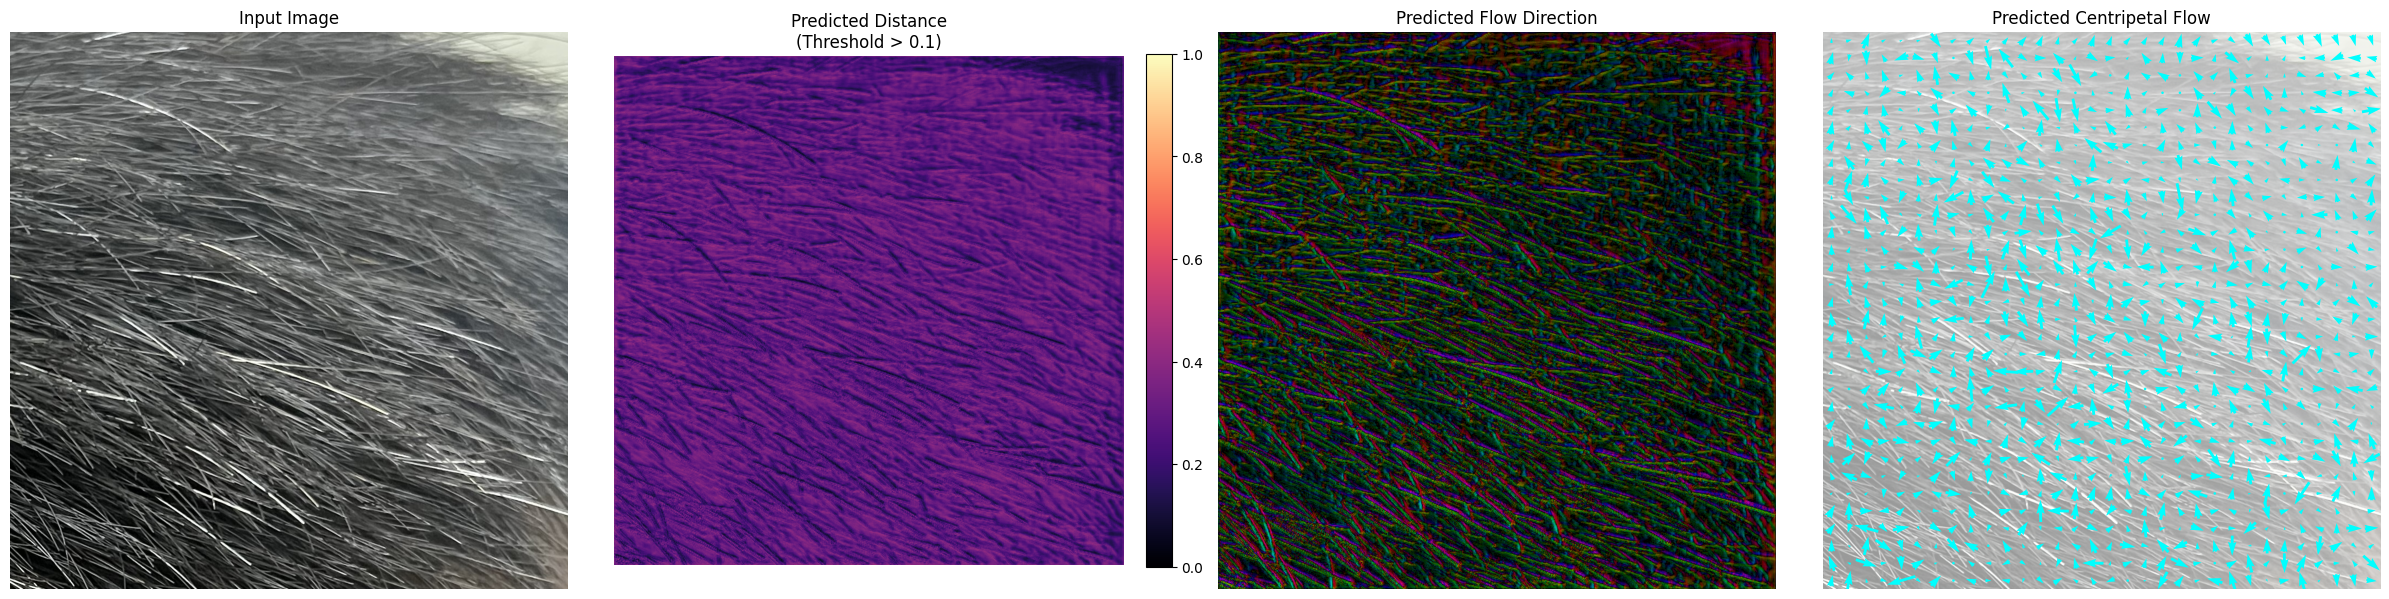

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

def visualize_test_inference(model, image_path, device='cuda', threshold=0.1):
    # 1. Load and Preprocess
    raw_image = cv2.imread(image_path)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    h, w = raw_image.shape[:2]

    # Use your Val Transform (Padding + Normalize)
    # Ensure this matches the 1024x1024 size your model expects
    transform = A.Compose([
        A.PadIfNeeded(min_height=1024, min_width=1024, position="center",
                      border_mode=cv2.BORDER_CONSTANT, value=0),
        A.CenterCrop(height=1024, width=1024),
        A.Normalize(),
        ToTensorV2()
    ])

    input_tensor = transform(image=raw_image)['image'].unsqueeze(0).to(device)

    # 2. Run Inference
    model.eval()
    with torch.no_grad():
        dist_pred, flow_pred = model(input_tensor)

    # 3. Post-process Tensors to Numpy
    # We remove the batch and channel dims for visualization
    dist_np = dist_pred.squeeze().cpu().numpy()
    flow_np = flow_pred.squeeze().permute(1, 2, 0).cpu().numpy() # (H, W, 2)

    # 4. Create the Plot
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Panel 1: Original Image (Cropped/Padded version)
    # Re-using denormalize helper for consistency
    img_display = denormalize_image(input_tensor.squeeze())
    axes[0].imshow(img_display)
    axes[0].set_title("Input Image")

    # Panel 2: Predicted Distance Ramp
    im1 = axes[1].imshow(dist_np, cmap='magma', vmin=0, vmax=1)
    axes[1].set_title(f"Predicted Distance\n(Threshold > {threshold})")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Panel 3: Predicted Flow Direction (Color coded)
    flow_rgb = flow_to_color(flow_np)
    axes[2].imshow(flow_rgb)
    axes[2].set_title("Predicted Flow Direction")

    # Panel 4: Sparse Vectors (Quiver)
    axes[3].imshow(img_display, alpha=0.4)
    step = 32
    y, x = np.mgrid[step//2:1024:step, step//2:1024:step]
    u = flow_np[::step, ::step, 0]
    v = flow_np[::step, ::step, 1]

    # Filter by predicted distance to show arrows only on "detected" hair
    mask = dist_np[::step, ::step] > threshold
    axes[3].quiver(x[mask], y[mask], u[mask], -v[mask],
                   color='cyan', scale=15, width=0.005, pivot='middle')
    axes[3].set_title("Predicted Centripetal Flow")

    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
TEST_IMAGE = '../data/test/right_cropped_tr.jpg'
visualize_test_inference(model, TEST_IMAGE)

/tmp/ipython-input-3268620711.py:18: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=1024, min_width=1024, position="center",


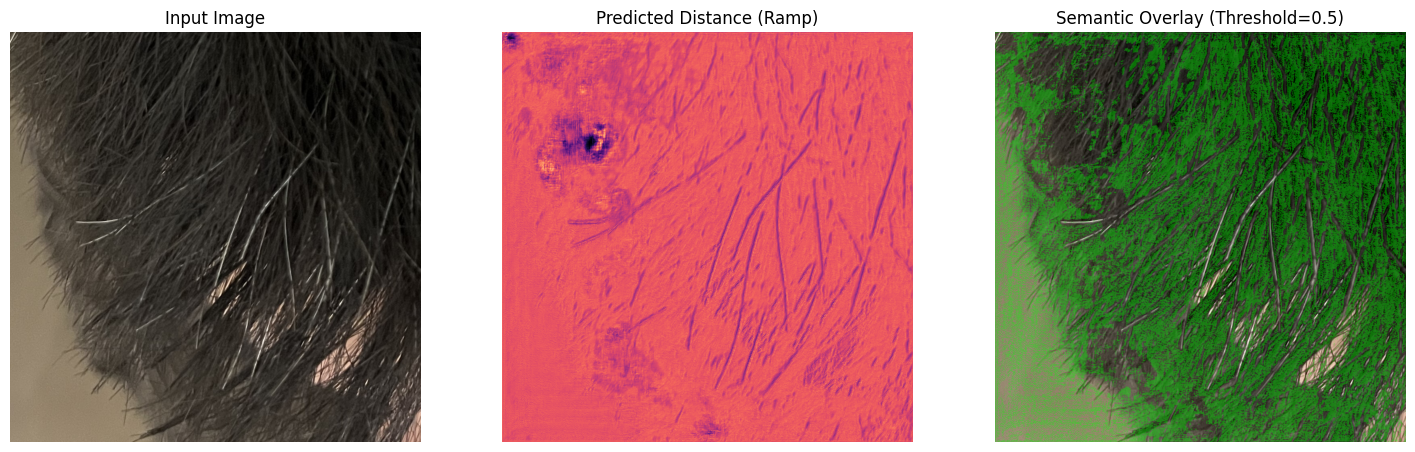

In [ ]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

def visualize_semantic_mask(model, image_path, device='cuda', threshold=0.1):
    """
    Predicts and visualizes the binary (semantic) mask on a test image.
    """
    model.eval()

    # 1. Load and Preprocess (Same as training/inference)
    raw_image = cv2.imread(image_path)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # Using the same transform logic you've established
    transform = A.Compose([
        A.PadIfNeeded(min_height=1024, min_width=1024, position="center",
                      border_mode=cv2.BORDER_CONSTANT, value=0),
        A.CenterCrop(height=1024, width=1024),
        A.Normalize(),
        ToTensorV2()
    ])

    input_tensor = transform(image=raw_image)['image'].unsqueeze(0).to(device)

    # 2. Forward Pass
    with torch.no_grad():
        dist_pred, _ = model(input_tensor) # Only need the distance head
        dist_np = dist_pred.squeeze().cpu().numpy()

    # 3. Thresholding to create the Binary Mask
    # dist_np is 0 to 1. Threshold 0.1 captures the base of the ramp.
    semantic_mask = (dist_np > threshold).astype(np.uint8)

    # 4. Create Visualization Overlay
    img_display = denormalize_image(input_tensor.squeeze())

    # Create a green tint for the mask
    overlay = img_display.copy()
    overlay[semantic_mask == 1] = [0, 1, 0] # Set hair pixels to Green

    # Blend the overlay with original image
    alpha = 0.4
    combined = cv2.addWeighted(overlay, alpha, img_display, 1 - alpha, 0)

    # 5. Plotting
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(dist_np, cmap='magma')
    plt.title("Predicted Distance (Ramp)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(combined)
    plt.title(f"Semantic Overlay (Threshold={threshold})")
    plt.axis('off')

    plt.show()

# Example usage:
TEST_IMAGE = '../data/test/top_cropped_bl.jpg'
# TEST_IMAGE = '../data/test/right_cropped_tr.jpg'
visualize_semantic_mask(model, TEST_IMAGE, threshold=0.5)

In [ ]:
%ls '../data/test/'


1_10_left.jpg    12_10_top.jpg   2_25_right.jpg    3_6_top.jpg
1_10_right.jpg   12_6_left.jpg   2_25_top.jpg      chipolte.jpg
1_10_top.jpg     12_6_right.jpg  3_6_left.jpg      girl_2.jpg
12_10_left.jpg   12_6_top.jpg    3_6_right.jpg     right_cropped_tr.jpg
12_10_right.jpg  2_25_left.jpg   3_6_top_high.jpg  top_cropped_bl.jpg


predict large image


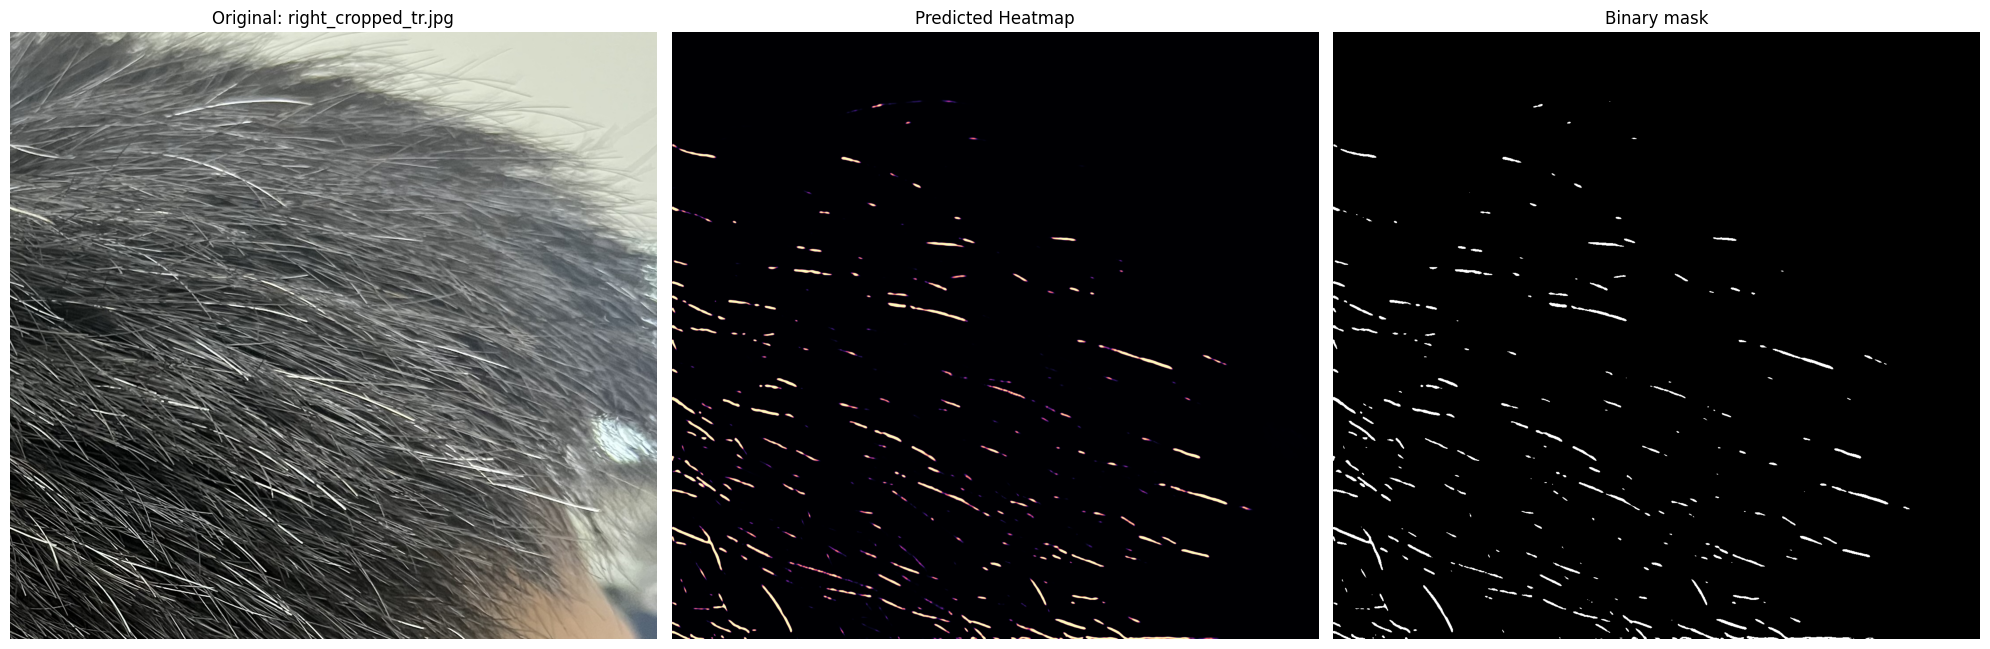

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. INPUTS
# ==========================================
# Define your paths
# MODEL_PATH = 'unet_hrnet_bce_only.pth' # Make sure this matches your save name
MODEL_PATH = 'unet_hrnet_flow_wmse.pth'
TEST_IMAGE = '../data/test/right_cropped_tr.jpg'
# TEST_IMAGE = 'white_hair_polyline/top_cropped_bl.jpg'
# TEST_IMAGE = 'white_hair_polyline/right_cropped_tr.jpg'
# TEST_IMAGE = 'white_hair_polyline/women_5.jpg'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================
# 2. LOAD MODEL & IMAGE
# ==========================================
# Note: Ensure the model class matches your training architecture
model = HairFlowModel(encoder="tu-hrnet_w18").cuda()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Load and prepare image
image_bgr = cv2.imread(TEST_IMAGE)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# ==========================================
# 3. RUN TILED PREDICTION
# ==========================================
# This calls the function that crops, predicts, and fuses 1024x1024 tiles
heat_map, flow_map = predict_large_image(model, image_rgb, tile_size=1024, device=DEVICE)
# heat_map, flow_map = predict_single_crop(model, image_rgb, device=DEVICE)

# ==========================================
# 4. VISUALIZATION
# ==========================================
# Convert predicted flow (cos2t, sin2t) to RGB for viewing
flow_rgb = flow_to_color(flow_map)

plt.figure(figsize=(20, 10))

# Plot Original
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title(f"Original: {os.path.basename(TEST_IMAGE)}")
plt.axis('off')

# Plot Mask (Heatmap)
plt.subplot(1, 3, 2)
# Use a colorful colormap for the probability map
plt.imshow(heat_map, cmap='magma')
# if using binary classification for hair/non hair pixel, we can use 0.5 as aggresive filter
# to filter out only spine of hair
binary_mask = (heat_map > 0.5).astype('uint8')
# print(f"Hair pixels found: {np.sum(binary_mask)}")
# plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Heatmap")
plt.axis('off')

## debug
plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary mask")
plt.axis('off')
## end of debug

# # Plot Flow Map (Colorized)
# plt.subplot(1, 3, 3)
# plt.imshow(flow_rgb)
# plt.title("Predicted Flow Orientation")
# plt.axis('off')

import cv2
# Convert RGB to BGR for OpenCV saving
# flow_bgr = cv2.cvtColor(flow_rgb, cv2.COLOR_RGB2BGR)
# debug ===============
flow_bgr = cv2.cvtColor(flow_rgb * binary_mask[..., np.newaxis], cv2.COLOR_RGB2BGR) # (H, W) -> (H, W, 3)
## end of debug ============
# Save the image
cv2.imwrite('/content/flow_visualization.png', flow_bgr)

plt.tight_layout()
plt.show()

In [ ]:
# Print the total count and list all file paths in the validation set
print(f"Total validation images: {len(val_imgs)}")
print("-" * 30)

for img_path in val_imgs:
    print(img_path)


print(f"\nTotal Train images: {len(train_imgs)}")
print("-" * 30)

for img_path in train_imgs:
    print(img_path)

Total validation images: 1
------------------------------
white_hair_polyline/women_5.jpg

Total Train images: 1
------------------------------
white_hair_polyline/top_cropped_bl.jpg


# Test count instance

In [ ]:
# import numpy as np
# import cv2
# from collections import deque
# from sklearn.neighbors import KDTree
# from tqdm import tqdm
# from skimage.morphology import skeletonize
# import matplotlib.pyplot as plt # Added import

# def get_skeleton_points(heat_map, threshold=0.5):
#     """
#     Converts heatmap to a binary mask and thins it to a 1-pixel skeleton.
#     Returns the 2D binary skeleton image.
#     """
#     print('get_skeleton_points')
#     binary_mask = (heat_map > threshold).astype(np.uint8)
#     skeleton = skeletonize(binary_mask)
#     return skeleton

# def get_avg_flow(point, flow_map, window=7):
#     """
#     Uses a larger window with Gaussian-like weighting to stabilize jittery flow.
#     """
#     h, w = flow_map.shape[:2]
#     y, x = int(round(point[0])), int(round(point[1]))

#     r = window // 2
#     y_min, y_max = max(0, y-r), min(h, y+r+1)
#     x_min, x_max = max(0, x-r), min(w, x+r+1)

#     local_flow = flow_map[y_min:y_max, x_min:x_max]

#     if local_flow.size == 0:
#         return np.array([0.0, 0.0])

#     # 1. Create a Gaussian-like weight kernel
#     # This gives higher priority to the center pixel
#     yy, xx = np.mgrid[-r:r+1, -r:r+1]
#     # Crop kernel if we are at the image boundary
#     kernel_y = yy[r - (y - y_min) : r + (y_max - y), r - (x - x_min) : r + (x_max - x)]
#     kernel_x = xx[r - (y - y_min) : r + (y_max - y), r - (x - x_min) : r + (x_max - x)]

#     sigma = window / 3.0
#     weights = np.exp(-(kernel_y**2 + kernel_x**2) / (2 * sigma**2))

#     # 2. Weighted average of the flow components
#     # We use 'np.average' which accepts a 'weights' parameter
#     avg_u = np.average(local_flow[..., 0], weights=weights)
#     avg_v = np.average(local_flow[..., 1], weights=weights)

#     # 3. Normalize to unit vector
#     norm = np.sqrt(avg_u**2 + avg_v**2) + 1e-8
#     return np.array([avg_u/norm, avg_v/norm])

# import numpy as np
# import cv2
# from collections import deque
# from tqdm import tqdm

# def momentum_spine_tracer(skeleton_mask, flow_map, eps=4.0, angle_weight=15.0):
#     h, w = skeleton_mask.shape
#     instance_map = np.zeros((h, w), dtype=np.int32)
#     visited = np.zeros((h, w), dtype=bool)
#     seeds = np.argwhere(skeleton_mask > 0)
#     current_label = 1

#     for seed in tqdm(seeds, desc="Tracing Hairs", unit="px"):
#         sy, sx = seed[0], seed[1]
#         if visited[sy, sx]: continue

#         queue = deque([(sy, sx)])
#         momentum = get_avg_flow((sy, sx), flow_map)

#         while queue:
#             cy, cx = queue.popleft()
#             if visited[cy, cx]: continue

#             visited[cy, cx] = True
#             curr_p = np.array([cy, cx])

#             # 1. PAINT
#             # cv2.circle(instance_map, (cx, cy), 3, int(current_label), -1)
#             instance_map[cy, cx] = current_label
#             ## end of debugging

#             # TIRED search for next best candiates(immediate_neibours pool + gap pool)
#             # 2. DEFINE SEARCH AREA (Standard Look Ahead)
#             # look_ahead = curr_p + (momentum * 1.5)
#             look_ahead = curr_p
#             # end of debugging ====
#             ly, lx = int(round(look_ahead[0])), int(round(look_ahead[1]))
#             r = int(eps) + 1
#             y0, y1 = max(0, ly - r), min(h, ly + r + 1)
#             x0, x1 = max(0, lx - r), min(w, lx + r + 1)
#             sub_mask = skeleton_mask[y0:y1, x0:x1]

#             if not np.any(sub_mask): continue

#             # Get all potential candidates in the window
#             local_y, local_x = np.where(sub_mask > 0)
#             all_candidates = []

#             # Pre-filter: Gather valid candidates first
#             for i in range(len(local_y)):
#                 cand_y = y0 + local_y[i]
#                 cand_x = x0 + local_x[i]

#                 if visited[cand_y, cand_x]: continue

#                 cand_p = np.array([cand_y, cand_x])
#                 spatial_dist = np.linalg.norm(cand_p - curr_p)

#                 if spatial_dist < 0.1: continue # Skip self

#                 # # Apply the "Forward Check" (Anti-U-Turn) here for SAFETY
#                 disp_vec = (cand_p - curr_p) / spatial_dist
#                 if np.dot(momentum, disp_vec) < 0.1: continue

#                 all_candidates.append((cand_p, spatial_dist))

#             # =========================================================
#             # [NEW] TIERED SEARCH LOGIC: "Walk before you Leap"
#             # =========================================================
#             best_cand_p = None
#             min_cost = float('inf')
#             best_cand_flow = None

#             # Step A: Filter for Immediate Neighbors (Touching pixels)
#             # Distance <= 1.8 covers diagonal pixels (sqrt(2) approx 1.414)
#             immediate_neighbors = [c for c in all_candidates if c[1] <= 1.8]

#             if len(immediate_neighbors) > 0:
#                 # PRIORITY 1: strict continuity.
#                 # Only evaluate cost among immediate neighbors.
#                 search_pool = immediate_neighbors
#             else:
#                 # PRIORITY 2: gap bridging.
#                 # Only search far candidates if no neighbors exist.
#                 search_pool = all_candidates

#             # Step B: Pick the best one from the selected pool
#             for (cand_p, spatial_dist) in search_pool:
#                 cand_y, cand_x = int(cand_p[0]), int(cand_p[1])
#                 cand_flow = get_avg_flow(cand_p, flow_map)

#                 # Calculate Cost (Same as before)
#                 dot = np.abs(np.dot(momentum, cand_flow))
#                 # angular_dist = (1.0 - np.clip(dot, 0, 1)) * angle_weight
#                 angular_dist = 0
#                 ## end debugging

#                 total_cost = spatial_dist + angular_dist

#                 if total_cost < min_cost:
#                     min_cost = total_cost
#                     best_cand_p = (cand_y, cand_x)
#                     best_cand_flow = cand_flow

#             # 5. UPDATE
#             if best_cand_p is not None:
#                 # Ambiguity check, avoid flow move backward
#                 if np.dot(momentum, best_cand_flow) < 0:
#                     best_cand_flow = -best_cand_flow
#                 # TODO(liq): adjust momentum
#                 momentum = (momentum * 0.4) + (best_cand_flow * 0.6)
#                 momentum /= (np.linalg.norm(momentum) + 1e-8)

#                 queue.append(best_cand_p)

#         current_label += 1

#     return instance_map
# # ==========================================
# # 1. INPUTS
# # ==========================================
# MODEL_PATH = 'unet_hrnet_flow_heatmap.pth'
# TEST_IMAGE = '../data/test/12_6_top.jpg'
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # ==========================================
# # 2. LOAD MODEL & IMAGE
# # ==========================================
# # Note: Ensure HairFlowModel is defined in your environment
# model = HairFlowModel(encoder="tu-hrnet_w18").to(DEVICE)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# model.eval()

# image_bgr = cv2.imread(TEST_IMAGE)
# image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# heat_map, flow_map = predict_large_image(model, image_rgb, tile_size=1024, device=DEVICE)
# skeleton_2d_mask = get_skeleton_points(heat_map, threshold=0.5)

# # Visualize skeleton
# import cv2
# # Ensure the data is in uint8 format
# mask_to_save = (skeleton_2d_mask * 255).astype(np.uint8)
# # Save the file
# cv2.imwrite('/content/skeleton_mask.png', mask_to_save)

# # # ==========================================
# # # 3. MOMENTUM-BASED TRACING
# # # ==========================================
# # # Use the same tracer we built; it works perfectly on skeleton points
# # final_instance_mask = momentum_spine_tracer(
# #     skeleton_2d_mask,
# #     flow_map,
# #     eps=2.0,           # Slightly higher eps helps bridge skeleton gaps
# #     angle_weight=0.0 # TODO(liq) use relation between angle and gaps distance to set eps and weight
# # )

# # # ==========================================
# # # 3. FILTERING OUT SMALL COMPONENTS
# # # ==========================================

# # def filter_labels_by_count(instance_mask, min_count=100):
# #     """
# #     1. Get unique labels.
# #     2. Count occurrence of each unique ID.
# #     3. Filter out labels based on count.
# #     """

# #     # Step 1: Get unique labels and Step 2: Count instances
# #     # return_counts=True gives us the pixel count for each label
# #     unique_labels, counts = np.unique(instance_mask, return_counts=True)

# #     # Identify which labels meet the criteria
# #     # We create a boolean mask for the counts array
# #     # We also ensure we don't accidentally count the background (0) as a valid hair
# #     is_large_enough = counts >= min_count
# #     is_not_background = unique_labels != 0

# #     # Combine conditions: Must be large enough AND not be background
# #     valid_labels_mask = is_large_enough & is_not_background

# #     # Get the actual list of IDs that passed
# #     valid_labels = unique_labels[valid_labels_mask]

# #     # Step 3: Filter out labels based on count
# #     # Create a mask where only valid labels are kept
# #     # np.isin checks if each pixel's value is in the 'valid_labels' list
# #     mask_to_keep = np.isin(instance_mask, valid_labels)

# #     # Create the final result: keep valid labels, set others to 0
# #     filtered_mask = np.where(mask_to_keep, instance_mask, 0)

# #     return filtered_mask, valid_labels

# # # ==========================================
# # # EXECUTION
# # # ==========================================
# # # Assuming 'final_instance_mask' is your output from the tracing step
# # # final_mask_clean, valid_ids = filter_labels_by_count(final_instance_mask, min_count=0)

# # # print(f"--- Filtering Summary ---")
# # # # Subtract 1 for background (0) if it exists in the original unique list
# # # original_count = len(np.unique(final_instance_mask)) - (1 if 0 in final_instance_mask else 0)
# # # print(f"Original Clusters: {original_count}")
# # # print(f"Remaining Clusters: {len(valid_ids)}")
# # # print(f"Filtered Out: {original_count - len(valid_ids)}")

# # # Visualize unique instances

# # def guaranteed_unique_color(label_mask):
# #     """
# #     Maps Label IDs to RGB colors with 0% chance of collision.
# #     Uses a bijective transformation to ensure visual distinctness.
# #     """
# #     # 1. Cast to uint32 to work with 24-bit integers safely
# #     # We copy to avoid modifying the original mask in place
# #     ids = label_mask.astype(np.uint32).copy()

# #     # 2. Bijective Scramble (The "Magic" Step)
# #     # We multiply by a large ODD number.
# #     # Because 2^24 and this odd number are coprime, this is a mathematically
# #     # guaranteed 1-to-1 mapping. No two IDs can produce the same result.
# #     prime_multiplier = 10738319

# #     # We scramble, then mask to 24 bits (0xFFFFFF)
# #     scrambled_ids = (ids * prime_multiplier) & 0xFFFFFF

# #     # 3. Split the 24-bit integer into three 8-bit channels
# #     r = (scrambled_ids >> 16) & 0xFF
# #     g = (scrambled_ids >> 8)  & 0xFF
# #     b = (scrambled_ids)       & 0xFF

# #     # 4. Stack into RGB image
# #     rgb_img = np.stack([r, g, b], axis=-1).astype(np.uint8)

# #     # 5. Force Background (Label 0) to Black
# #     # The scramble might turn 0 into a valid color, so we explicitly reset it
# #     rgb_img[label_mask == 0] = [0, 0, 0]

# #     return rgb_img

# # # ==========================================
# # # 1. GENERATE RGB IMAGE
# # # ==========================================
# # # Assuming 'final_mask_clean' is your filtered label mask from the previous step
# # # colorized_result = guaranteed_unique_color(final_mask_clean)
# # colorized_result = guaranteed_unique_color(final_instance_mask)

# # # ==========================================
# # # 2. DISPLAY IN NOTEBOOK
# # # ==========================================
# # plt.figure(figsize=(15, 15))
# # plt.imshow(colorized_result)
# # # plt.title(f"Unique Instance Visualization ({np.max(final_mask_clean)} Hairs)")
# # plt.title(f"Unique Instance Visualization ({np.max(final_instance_mask)} Hairs)")
# # plt.axis('off')
# # plt.show()

# # # ==========================================
# # # 3. SAVE HIGH-RES OUTPUT
# # # ==========================================
# # # Note: OpenCV uses BGR order, so we flip the channels before saving
# # bgr_result = cv2.cvtColor(colorized_result, cv2.COLOR_RGB2BGR)
# # save_path = '/content/final_hair_instances_colored.png'
# # cv2.imwrite(save_path, bgr_result)

# # print(f"Saved visualization to: {save_path}")

In [ ]:
import cv2
import numpy as np

# 1. Expand the skeleton mask to include its 8-neighbors
# A 3x3 kernel covers the center pixel + 1 pixel in every direction
kernel = np.ones((3, 3), np.uint8)
expanded_mask = cv2.dilate(skeleton_2d_mask.astype(np.uint8), kernel, iterations=1)

# 2. Mask the original flow_map using the expanded mask
# This keeps original flow_map values at those pixels and sets others to 0
masked_flow_map = flow_map * expanded_mask[...,None]
print(flow_map.shape)

# 3. Save as PNG
# Convert the 2-channel flow to a 3-channel RGB image for visualization
vis_flow = flow_to_color(masked_flow_map)
cv2.imwrite('/content/flow_map_skeleton.png', cv2.cvtColor(vis_flow, cv2.COLOR_RGB2BGR))
# heatmap_to_save = (masked_flow_map * 255).astype(np.uint8)
# cv2.imwrite('/content/skeleton_neighborhood_heatmap.png', vis_flow)
np.save('/content/flow_data.npy', masked_flow_map)

NameError: name 'skeleton_2d_mask' is not defined

In [ ]:
# import numpy as np

# # Get unique labels and their respective counts
# unique_labels, counts = np.unique(labels, return_counts=True)

# # 1. Find the Maximum Label (Total Clusters)
# # Since labels are 0-indexed, the max label + 1 is the cluster count
# max_label = np.max(unique_labels)
# total_hairs = max_label + 1 if max_label >= 0 else 0

# # 2. Extract Noise Count
# # Noise is always label -1
# noise_idx = np.where(unique_labels == -1)[0]
# noise_count = counts[noise_idx[0]] if len(noise_idx) > 0 else 0

# print(f"--- DBSCAN Results Summary ---")
# print(f"Total Hair Pixels: {len(labels)}")
# print(f"Max Label ID:      {max_label}")
# print(f"Total Clusters:    {total_hairs}")
# print(f"Noise Points:      {noise_count} ({(noise_count/len(labels))*100:.1f}%)")
# print(f"------------------------------")

# Test BCEDice loss model

In [ ]:
# test dice loss
MODEL_PATH = 'unet_polyline.pth'
TEST_IMAGE = image_paths[train_size]

run_inference_on_image(MODEL_PATH, TEST_IMAGE)

NameError: name 'image_paths' is not defined

## DEBUG, Hair Pixel Distribution

In [ ]:
print(heat_map.min(), heat_map.max())

6.287554e-05 0.9999998


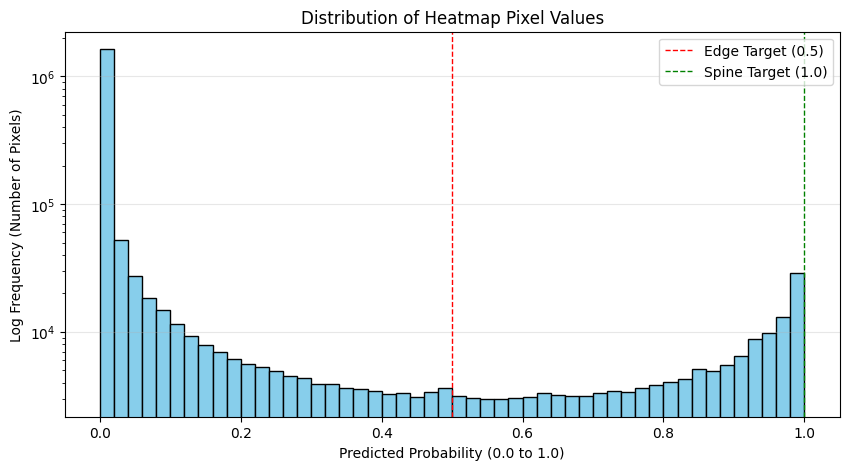

In [ ]:


plot_heatmap_distribution(heat_map)